In [1]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 112.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [83]:
data_dir = "/content/drive/MyDrive/Диплом 2025/notebooks/data/raw"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv(f'{data_dir}/HI-Small_Trans.csv')

# Предобработка данных

Перемешиваем данные

In [250]:
df = df.sample(frac=1).reset_index(drop=True) # перемешиваем данные

In [251]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/07 08:26,6129,80349D400,139793,80EB1AA20,6260.67,Swiss Franc,6260.67,Swiss Franc,ACH,1
1,2022/09/07 08:36,2439,8011DD900,21940,802773240,30.68,US Dollar,30.68,US Dollar,ACH,0
2,2022/09/03 14:09,212,80767CAF0,15010,80278F960,4023.45,Euro,4023.45,Euro,ACH,1
3,2022/09/10 17:12,10642,808161D70,3144,8082681B0,38295.79,US Dollar,38295.79,US Dollar,ACH,1
4,2022/09/01 08:14,70,100428660,13037,8027CF570,1009.24,US Dollar,1009.24,US Dollar,Cheque,1


In [252]:
from datetime import datetime

def str_to_unix(str_datetime):
  date_obj = datetime.strptime(str_datetime, '%Y/%m/%d %H:%M')  # преобразуем строку в datetime
  return int(date_obj.timestamp())  # получаем Unix-время (секунды)


df['Timestamp'] = df['Timestamp'].apply(str_to_unix)

In [253]:
categorical_label = ['Account', 'Account.1']
categorical_space = ['Receiving Currency', 'Payment Currency', 'Payment Format']

In [254]:
from sklearn.preprocessing import LabelEncoder

account_encoder = LabelEncoder()

accounts = np.concatenate([df['Account'].unique(), df['Account.1'].unique()])

account_encoder.fit(accounts)

LabelEncoder()

In [255]:
df['Account'] = account_encoder.transform(df['Account'])
df['Account.1'] = account_encoder.transform(df['Account.1'])

In [256]:
# for category in categorical_space:

# One-Hot Encoding
df_encoded = pd.get_dummies(
    df[categorical_space],
    prefix=categorical_space,  # Добавляет префикс (например, "Account_A")
    prefix_sep='_',            # Разделитель (можно изменить на "/" или другой)
    drop_first=False,          # Не удалять первую категорию (чтобы были все варианты)
    dtype=int                  # 0/1 вместо True/False
)

df_encoded.head()

,Receiving Currency_Australian Dollar,Receiving Currency_Bitcoin,Receiving Currency_Brazil Real,Receiving Currency_Canadian Dollar,Receiving Currency_Euro,Receiving Currency_Mexican Peso,Receiving Currency_Ruble,Receiving Currency_Rupee,Receiving Currency_Saudi Riyal,Receiving Currency_Shekel,...,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [257]:
# Объединяем с исходным DataFrame (если нужно)
df_final = pd.concat([df.drop(categorical_space, axis=1), df_encoded], axis=1)

In [258]:
df_final.isna().sum()

,0
Timestamp,0
From Bank,0
Account,0
To Bank,0
Account.1,0
Amount Received,0
Amount Paid,0
Is Laundering,0
Receiving Currency_Australian Dollar,0
Receiving Currency_Bitcoin,0


<Axes: xlabel='Is Laundering'>

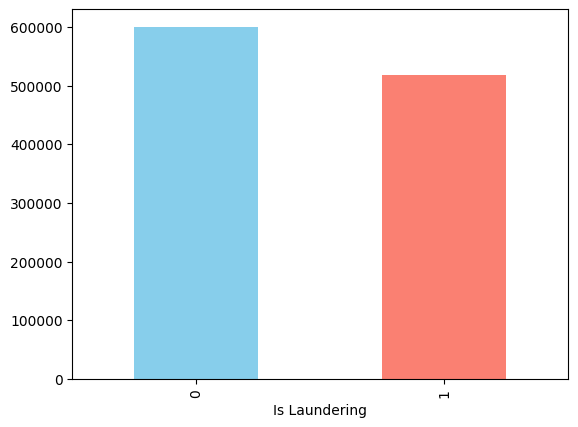

In [259]:
(df_final['Is Laundering'].value_counts()).plot(kind='bar', color=['skyblue', 'salmon'])

# Обучение классических моделей

In [192]:
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [96]:
X, y = df_final.drop(['Is Laundering'], axis=1), df_final['Is Laundering']

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [98]:
estimator = Pipeline([
    ('clf', LogisticRegression())
])


estimate_param_grid = [{
    'clf': [
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
        SVC(random_state=0),
        LinearSVC(random_state=0),
        PassiveAggressiveClassifier(random_state=0),
        RandomForestClassifier(random_state=0),
        ExtraTreesClassifier(random_state=0),
        RidgeClassifier(random_state=0),
        MLPClassifier(random_state=0),
        xgb.XGBClassifier()

        # SGDClassifier(loss='hinge', random_state=0),  # LinearSVC
        # SGDClassifier(loss='log_loss', random_state=0),  # LogisticRegression
        # SGDClassifier(loss='modified_huber', random_state=0),  # толерантность к выбросам
        # SGDClassifier(loss='squared_hinge', random_state=0),  # SVC с квадратичным штрафом
        # SGDClassifier(loss='perceptron', random_state=0),  # MLP
    ]
}]

scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

grid_search = GridSearchCV(
    estimator,
    estimate_param_grid,
    scoring=scoring,
    refit='f1_weighted',
    cv=3,
    verbose=4,
    n_jobs=4,
)

In [99]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=ConvergenceWarning)
    warnings.simplefilter('ignore', category=UndefinedMetricWarning)
    grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [100]:
keys = [
    'params',
    'mean_test_f1_weighted',
    'mean_test_accuracy',
    'mean_test_precision_weighted',
    'mean_test_recall_weighted',
    'mean_test_roc_auc'
]

report = pd.DataFrame(grid_search.cv_results_)[keys]
report['params'] = report['params'].apply(lambda x: str(x['clf']).replace('random_state=0', ''))
report = report.rename(columns=lambda x: x.replace('_test', '').replace('_weighted', '').replace('mean_', ''))

In [101]:
results = report.sort_values('f1', ascending=False)

In [102]:
results = results.reset_index(drop=True)
results['params'] = results['params'].apply(lambda x: x.split('(')[0])

In [2]:
results

,model,f1,accuracy,avg_precision,avg_recall,roc_auc
0,XGBClassifier,0.91,0.91,0.91,0.90,0.96
1,RandomForestClassifier,0.90,0.91,0.90,0.90,0.95
2,ExtraTreesClassifier,0.90,0.90,0.90,0.89,0.95
3,RidgeClassifier,0.87,0.87,0.87,0.87,0.92
4,KNeighborsClassifier,0.66,0.67,0.67,0.67,0.67
5,LogisticRegression,0.44,0.54,0.54,0.54,0.55
6,LinearSVC,0.38,0.54,0.53,0.54,0.55
7,SVC,0.37,0.54,0.29,0.54,0.64
8,PassiveAggressiveClassifier,0.37,0.54,0.29,0.54,0.37
9,MLPClassifier,0.32,0.49,0.35,0.49,0.50


# Графовые нейронные сети

In [37]:
%pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [225]:
import torch_geometric

In [260]:
df_accounts_paid = df_final['Account'].unique()
df_accounts_recieved = df_final['Account.1'].unique()

In [261]:
account_nodes_paid = df[['Account', 'From Bank', 'Payment Currency']].drop_duplicates(subset=["Account", 'From Bank'])
account_nodes_received = df[["Account.1", 'To Bank', 'Receiving Currency']].drop_duplicates(subset=["Account.1", 'To Bank'])
account_nodes_paid.rename(columns={'Payment Currency': 'Currency'}, inplace=True)
account_nodes_received.rename(columns={"Account.1": "Account", 'Receiving Currency': 'Currency'}, inplace=True)
account_nodes_paid.rename(columns={'From Bank': 'Bank'}, inplace=True)
account_nodes_received.rename(columns={"To Bank": "Bank", 'Account.1': 'Account'}, inplace=True)

account_nodes = pd.concat([account_nodes_paid, account_nodes_received], axis=0).sample(frac=1).reset_index(drop=True)

In [262]:
account_nodes.head()

,Account,Bank,Currency
0,10815,19746,US Dollar
1,10099,213952,US Dollar
2,14037,221130,US Dollar
3,6427,8771,US Dollar
4,12252,14433,US Dollar


In [263]:
account_nodes_final = pd.concat([account_nodes.drop(['Currency'], axis=1), pd.get_dummies(account_nodes['Currency'],  dtype=int)], axis=1)
account_nodes_final.head()

,Account,Bank,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,Swiss Franc,UK Pound,US Dollar,Yen,Yuan
0,10815,19746,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,10099,213952,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,14037,221130,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,6427,8771,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,12252,14433,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [264]:
account_to_tensor_idx = dict(zip(map(lambda x: x, account_nodes_final['Account']), range(account_nodes_final.shape[0])))

In [265]:
# 1. Признаки узлов (Features)
num_nodes = len(account_nodes)
node_features = torch.tensor(account_nodes_final.values)

In [266]:
src = df['Account'].apply(lambda x: account_to_tensor_idx[x]).values
dest = df['Account.1'].apply(lambda x: account_to_tensor_idx[x]).values

In [267]:
# 2. Рёбра (Edges) в формате [2, num_edges]
edge_index = torch.tensor([src, dest], dtype=torch.long)

In [268]:
edge_features = df[['Timestamp', 'Amount Received', 'Payment Format']]

In [269]:
edge_features.head()

,Timestamp,Amount Received,Payment Format
0,1662539160,6260.67,ACH
1,1662539760,30.68,ACH
2,1662214140,4023.45,ACH
3,1662829920,38295.79,ACH
4,1662020040,1009.24,Cheque


## Нормализация

In [270]:
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler

amount_scaler = RobustScaler()
amount_scaled = amount_scaler.fit_transform(edge_features['Amount Received'].values.reshape(1, -1))

time_scaler = MinMaxScaler()
time_scaled = time_scaler.fit_transform(edge_features['Timestamp'].values.reshape(1, -1))

edge_features_scaled = pd.concat([pd.Series(time_scaled.reshape(-1), name="Timestamp"), pd.Series(amount_scaled.reshape(-1), name='Amount'), edge_features["Payment Format"].reset_index(drop=True)], axis=1)
edge_features_scaled.shape
edge_features_scaled = pd.DataFrame()

edge_features_scaled['Timestamp'] = edge_features['Timestamp'].reset_index(drop=True)
edge_features_scaled['Amount'] = edge_features['Amount Received'].reset_index(drop=True)
edge_features_scaled['Payment Format'] = edge_features["Payment Format"].reset_index(drop=True)

In [271]:
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler

amount_scaler = RobustScaler()
amount_scaled = amount_scaler.fit_transform(np.log10(edge_features['Amount Received'].values.reshape(-1, 1) + 1))

time_scaler = StandardScaler()
time_scaled = time_scaler.fit_transform(edge_features['Timestamp'].values.reshape(-1, 1))

edge_features_scaled = pd.concat([pd.Series(time_scaled.reshape(-1), name="Timestamp"), pd.Series(amount_scaled.reshape(-1), name='Amount'), edge_features["Payment Format"].reset_index(drop=True)], axis=1)

In [272]:
edge_features_final = pd.concat([edge_features_scaled.drop(['Payment Format'], axis=1), pd.get_dummies(edge_features_scaled['Payment Format'], dtype=int)], axis=1)

In [273]:
edge_attrs = torch.tensor(edge_features_final.values, dtype=float)

In [274]:
one_hot_y = torch.eye(2)
classes_y = one_hot_y[df['Is Laundering'].values]

## Инициализация графа

In [275]:
from torch_geometric.data import Data

# Разделим данные на train/test (упрощённый вариант)
train_mask = torch.randperm(classes_y.size(0)) < int(0.8 * classes_y.size(0))
test_mask = ~train_mask

# 4. Создание графа
graph = Data(
    x=node_features.float(),          # Признаки узлов [num_nodes, num_features]
    edge_index=edge_index,    # Рёбра [2, num_edges]
    edge_attr=edge_attrs,    # Признаки рёбер (опционально)
    y=classes_y,
    dtype=torch.float, train_mask=train_mask, test_mask=test_mask)

graph.x = graph.x.to(device).float()
graph.y = graph.y.to(device).float()
graph.edge_attr = graph.edge_attr.to(device).float()
graph.edge_index = graph.edge_index.to(device)

## Архитектура модели GNN

In [277]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, TransformerConv, TAGConv
from torch_geometric.data import Data

class AmlGnnClassifier(torch.nn.Module):
    def __init__(self, nodes: torch.tensor, edges: torch.tensor, num_classes):
        super().__init__()

        # GNN-слои для узлов
        self.conv1 = GINEConv(nn=torch.nn.Sequential(
            torch.nn.Linear(nodes.shape[1], 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        ), edge_dim=edges.shape[1])
        self.conv2 =  GINEConv(nn=torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128)
        ), edge_dim=edges.shape[1])
        self.conv3 =  GINEConv(nn=torch.nn.Linear(128, 64), edge_dim=edges.shape[1])
        self.conv4 =  GINEConv(nn=torch.nn.Linear(64, 128), edge_dim=edges.shape[1])
        self.tag1 = TAGConv(128, 128, K=3)
        self.transformer1 = TransformerConv(128, 128, edge_dim=edges.shape[1])
        self.conv5 =  GINEConv(nn=torch.nn.Linear(128, 64), edge_dim=edges.shape[1])
        self.conv6 =  GINEConv(nn=torch.nn.Linear(64, 128), edge_dim=edges.shape[1])
        self.conv7 =  GINEConv(nn=torch.nn.Linear(128, 256), edge_dim=edges.shape[1])
        self.conv8 =  GINEConv(nn=torch.nn.Linear(256, 256), edge_dim=edges.shape[1])
        self.transformer2 = TransformerConv(256, 256, edge_dim=edges.shape[1])
        self.conv9 =  GINEConv(nn=torch.nn.Linear(256, 512), edge_dim=edges.shape[1])

        # MLP для классификации рёбер
        # Вход: эмбеддинги узлов (source + target)
        self.edge_classifier = torch.nn.Sequential(
            torch.nn.Linear(512 * 2, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
            torch.nn.SELU(),
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.selu(self.conv1(x, edge_index, edge_attr))
        x = F.selu(self.conv2(x, edge_index, edge_attr))
        x = F.selu(self.conv3(x, edge_index, edge_attr))
        x = F.selu(self.conv4(x, edge_index, edge_attr))
        x = F.selu(self.tag1(x, edge_index))
        x = F.selu(self.transformer1(x, edge_index, edge_attr))
        x = F.selu(self.conv5(x, edge_index, edge_attr))
        x = F.selu(self.conv6(x, edge_index, edge_attr))
        x = F.selu(self.conv7(x, edge_index, edge_attr))
        x = F.selu(self.conv8(x, edge_index, edge_attr))
        x = F.selu(self.transformer2(x, edge_index, edge_attr))
        x = F.selu(self.conv9(x, edge_index, edge_attr))


        # Получаем эмбеддинги для source и target узлов каждого ребра
        src, dst = edge_index
        x_src = x[src]  # Эмбеддинги узлов-источников [num_edges, hidden_channels]
        x_dst = x[dst]  # Эмбеддинги узлов-целей [num_edges, hidden_channels]

        # Конкатенируем эмбеддинги узлов и признаки ребра
        edge_features = torch.cat([x_src, x_dst], dim=-1)

        # Предсказываем класс ребра
        return F.softmax(self.edge_classifier(edge_features))

## Обучение

In [278]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics


def test_model(model):# Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(x=graph.x, edge_index=graph.edge_index[:, test_mask], edge_attr=graph.edge_attr[test_mask])
        pred_classes = pred.argmax(dim=1)
        true_classes = graph.y.argmax(dim=1)
        acc = accuracy_score(true_classes[test_mask].detach().cpu(), pred_classes.detach().cpu())
        return acc

def save_model(model, optimizer, loss, name_model):
    # Сохранение модели
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f'{name_model}.pth')
    print(f"Модель сохранена в {name_model}.pth")

def display_confusion_matrix(y_test, y_pred):
  cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    # display_labels=y,
    colorbar=False,
    cmap=sns.color_palette('light:b', as_cmap=True)
    )
  cm_display.ax_.grid(False)
  cm_display.figure_.set_size_inches(6, 6)

def test_model_with_loader(model, loader):
    model.eval()


    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr)
            pred = out.argmax(dim=1)
            total_correct += (pred == data.y).sum().item()
            total_samples += data.y.size(0)
    return total_correct / total_samples

def train_with_loader(loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for subgraph in loader:
        subgraph = subgraph.to(device)
        optimizer.zero_grad()

        # Предсказание для всех рёбер в подграфе
        out = model(x=subgraph.x.float(), edge_index=subgraph.edge_index, edge_attr=subgraph.edge_attr.float())

        # Используем только обучающие рёбер из подграфа
        train_mask = subgraph.train_mask  # Маска внутри подграфа
        loss = criterion(out[train_mask], subgraph.y[train_mask])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test():
    # model.eval()
    correct = 0
    with torch.no_grad():
        # Предсказание для всех узлов
        out = model(graph.x.to(device), graph.edge_index.to(device))
        # Используем тестовую маску
        pred = out[graph.test_mask].argmax(dim=1)
        correct = (pred == graph.y[graph.test_mask].to(device)).sum().item()
    return correct / graph.test_mask.sum()

In [306]:
from sklearn.metrics import accuracy_score

import warnings

# Отключить все предупреждения
warnings.filterwarnings("ignore")

model = AmlGnnClassifier(edges=graph.edge_attr, nodes=graph.x, num_classes=2).to(device)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
# optimizer = Lion(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.7)
# Пример для GAT (Graph Attention Network)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.8, 1])).to(device)  # BCEWithLogitsLoss, если y бинарный

best_test_acc = 0
# Цикл обучения
model.train()

train_acc_l = []
test_acc_l = []

epochs=1500

for epoch in range(epochs):
    optimizer.zero_grad()

    # Предсказание классов рёбер
    train_pred = model(x=graph.x, edge_index=graph.edge_index[:,train_mask], edge_attr=graph.edge_attr[train_mask])

    # Ошибка только на обучающих рёбрах
    train_loss = criterion(train_pred, graph.y[train_mask])  # Если y one-hot

    test_pred = model(x=graph.x, edge_index=graph.edge_index[:,test_mask], edge_attr=graph.edge_attr[test_mask])
    test_loss = criterion(graph.y[graph.test_mask], test_pred)

    train_loss.backward()
    optimizer.step()


    # train_losses.append(train_loss.item())
    cur_acc = test_model(model)


    train_acc_l.append(accuracy_score(graph.y[train_mask].argmax(dim=1).detach().cpu(),train_pred.argmax(dim=1).detach().cpu()))
    test_acc_l.append(cur_acc)


    if epoch > 100 and cur_acc > best_test_acc:
        save_model(model, optimizer, train_loss, 'model2')
        print(f"best test accuracy: {cur_acc + 0.003}")
        best_test_acc = cur_acc

    if epoch % 1 == 0:
        print(f'Epoch {epoch}, train Loss: {train_loss.item():.4f}, Acc: {cur_acc + 0.003}')

Epoch 0, train Loss: 0.6142, Acc: 0.6398515205724508
Epoch 1, train Loss: 0.5870, Acc: 0.6407459749552773
Epoch 2, train Loss: 0.5790, Acc: 0.6313542039355993
Epoch 3, train Loss: 0.5701, Acc: 0.6407459749552773
Epoch 4, train Loss: 0.5594, Acc: 0.6555044722719141
Epoch 5, train Loss: 0.5487, Acc: 0.672051878354204
Epoch 6, train Loss: 0.5396, Acc: 0.7453971377459749
Epoch 7, train Loss: 0.5335, Acc: 0.7816225402504472
Epoch 8, train Loss: 0.5321, Acc: 0.7878837209302325
Epoch 9, train Loss: 0.5232, Acc: 0.7896726296958855
Epoch 10, train Loss: 0.5145, Acc: 0.8039838998211091
Epoch 11, train Loss: 0.5106, Acc: 0.8473649373881932
Epoch 12, train Loss: 0.5057, Acc: 0.8460232558139535
Epoch 13, train Loss: 0.5015, Acc: 0.8572039355992844
Epoch 14, train Loss: 0.4946, Acc: 0.8482593917710197
Epoch 15, train Loss: 0.4878, Acc: 0.8625706618962433
Epoch 16, train Loss: 0.4757, Acc: 0.8688318425760286
Epoch 17, train Loss: 0.4668, Acc: 0.8630178890876565
Epoch 18, train Loss: 0.4603, Acc: 0.86

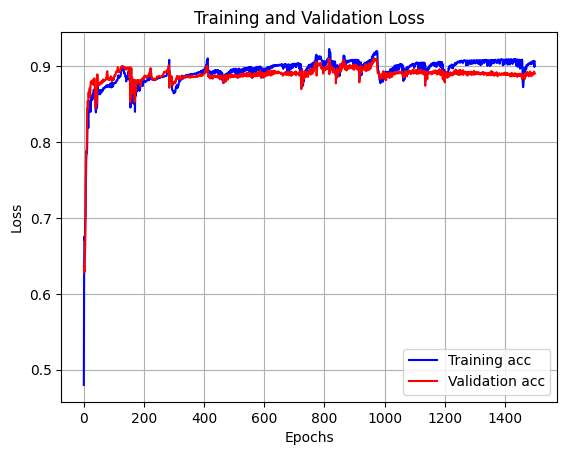

In [307]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_acc_l, 'b', label='Training acc')
plt.plot(range(epochs), test_acc_l, 'r', label='Validation acc')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.83      0.90    502031
           1       0.85      0.98      0.91    502031

    accuracy                           0.91   1004062
   macro avg       0.92      0.91      0.91   1004062
weighted avg       0.92      0.91      0.91   1004062



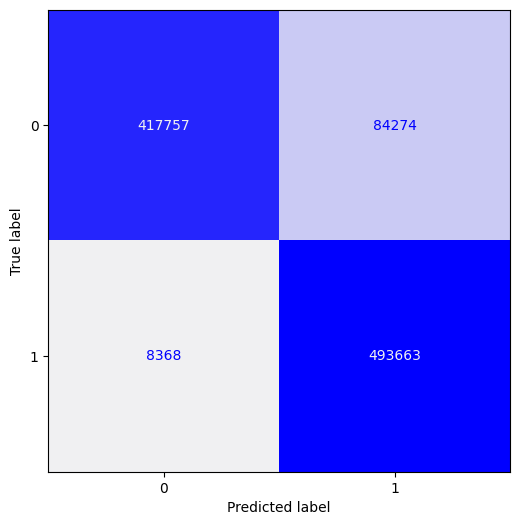

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

# Инициализация модели (архитектура должна совпадать!)
loaded_model = AmlGnnClassifier(edges=graph.edge_attr, nodes=graph.x, num_classes=2).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.001)
# optimizer = Lion(model.parameters(), lr=0.001)

# Загрузка
checkpoint = torch.load('model2.pth', map_location=torch.device('cpu'))
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_loss = checkpoint['loss']

# Проверка
loaded_model.eval()
with torch.no_grad():
    pred = loaded_model(graph.x, graph.edge_index[:, test_mask], graph.edge_attr[test_mask]).detach().cpu()
    pred_classes = pred.argmax(dim=1).detach().cpu()
    true_classes = graph.y[test_mask].argmax(dim=1).detach().cpu()
    print(classification_report(true_classes, pred_classes))
    display_confusion_matrix(true_classes, pred_classes)

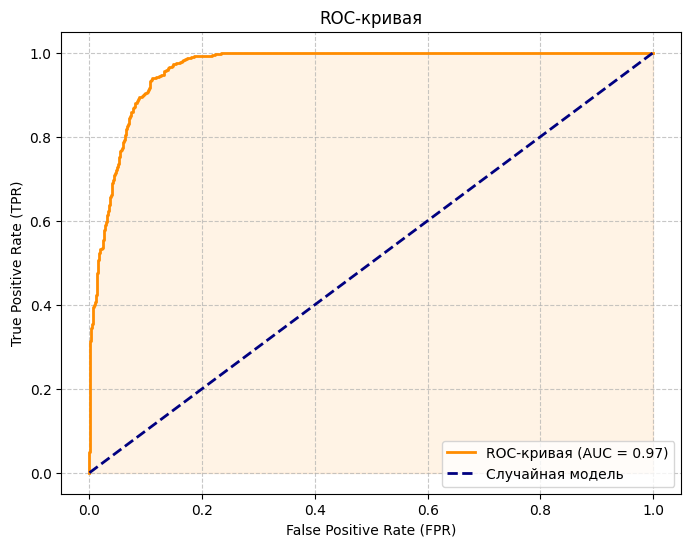

In [334]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Рассчет ROC-кривой
fpr, tpr, thresholds = roc_curve(true_classes.cpu().detach(), pred[:, 1].cpu().detach())
auc = roc_auc_score(true_classes, pred[:, 1])
roc_auc = metrics.auc(fpr, tpr)
# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайная модель')
plt.fill_between(fpr, tpr, alpha=0.1, color='darkorange')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Сравнение моделей

In [341]:
# Словарь моделей
models = {
    "LogisticRegression": LogisticRegression(random_state=0, max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(probability=True, random_state=0),
    "LinearSVC": LinearSVC(random_state=0, max_iter=10000),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(random_state=0, max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "RidgeClassifier": RidgeClassifier(random_state=0),
    "MLPClassifier": MLPClassifier(random_state=0, max_iter=1000),
    "XGBClassifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [342]:
# Обучение и предсказания
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(X_test)[:, 1]  # для ROC-AUC
    else:
        y_pred = model.decision_function(X_test)  # для моделей без predict_proba
    predictions[name] = y_pred

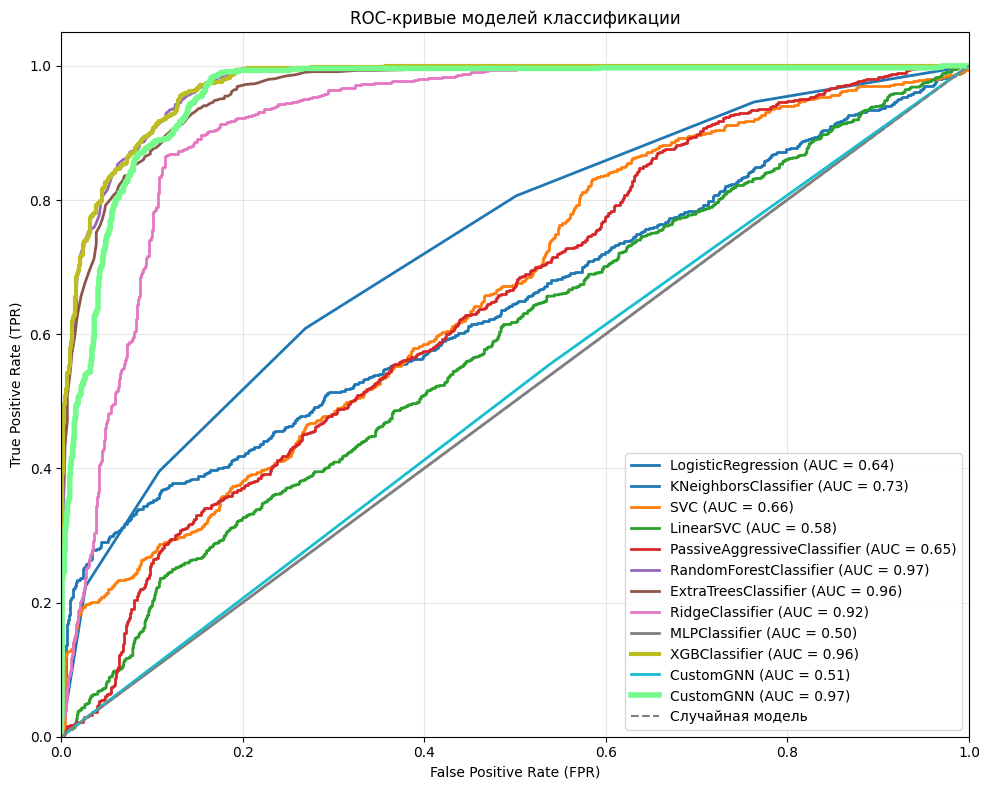

In [343]:
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(predictions) + 1))  # уникальные цвета

for (name, predict), color in zip(predictions.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, predict)
    roc_auc = roc_auc_score(y_test, predict)  # используем текущие predict, а не y_pred
    lw = 2
    if name == 'XGBClassifier':
      lw = 3
    plt.plot(fpr, tpr, color=color, lw=lw,
             label=f"{name} (AUC = {roc_auc:.2f})")


# Рассчет ROC-кривой
fpr, tpr, thresholds = roc_curve(true_classes, pred[:, 1])
auc = roc_auc_score(true_classes, pred[:, 1])
plt.plot(fpr, tpr, color='#75FA8D', lw=4, label=f"CustomGNN (AUC = {auc:.2f})")

# Добавим диагональ (случайная модель)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Случайная модель')

# Настройки графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-кривые моделей классификации")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


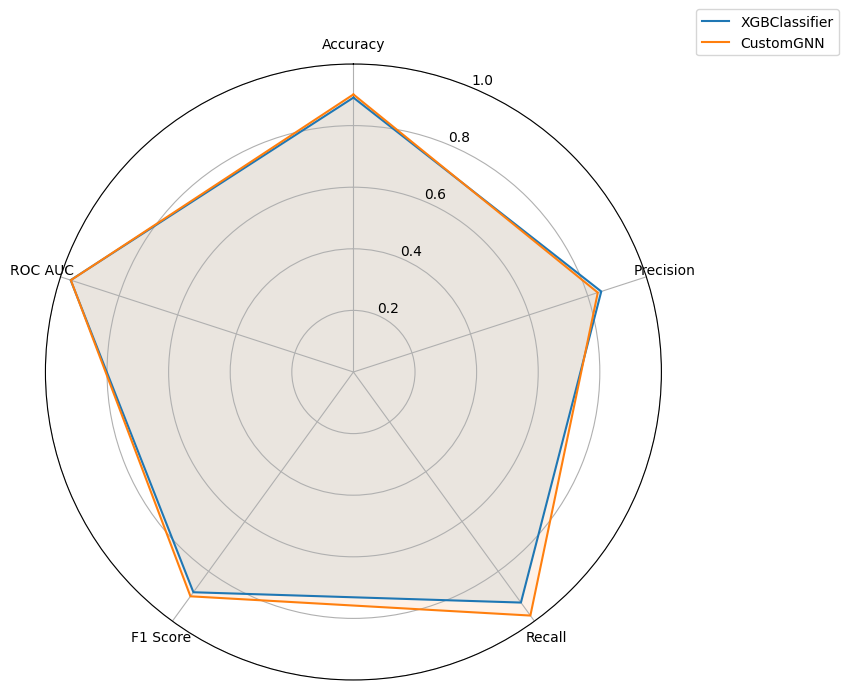

In [350]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Метрики
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
results = {}


best_models = ['XGBClassifier']

for name in best_models:
    preds = predictions[name]
    binarized_preds = (preds >= 0.5).astype(int)  # если preds — вероятности
    results[name] = [
        accuracy_score(y_test, binarized_preds),
        precision_score(y_test, binarized_preds),
        recall_score(y_test, binarized_preds),
        f1_score(y_test, binarized_preds),
        roc_auc_score(y_test, preds)
    ]

results['CustomGNN'] = [
     accuracy_score(true_classes, pred_classes),
        precision_score(true_classes, pred_classes),
        recall_score(true_classes, pred_classes),
        f1_score(true_classes, pred_classes),
        roc_auc_score(true_classes, pred[:, 1].numpy())
]

# Подготовка к радар-чарту
labels = np.array(metrics)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # замыкаем круг

# Построение графика
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for name, scores in results.items():
    values = scores + scores[:1]  # замкнуть график
    ax.plot(angles, values, label=name)
    ax.fill(angles, values, alpha=0.1)

# Настройки
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))


plt.show()
